# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import math 
import numpy as np
import pandas as pd
import math #needed for later
import seaborn as sns
import time
import statistics

import lightgbm as lgb
from catboost import CatBoostRegressor #we need regression not classification
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

from sklearn.model_selection import KFold #We're using cross-validation for this.
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from IPython.display import display

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

#Passing the new parse_dates argument to the read_csv() function means you don't have to call the pd.to_datetime() *function.*
#Passing the index_col (index column) argument to the read_csv() function means you don't have to call the df.set_index() function.

In [3]:
taxi = taxi.sort_index()
print(taxi.index.is_monotonic)
print(taxi.info())

#To check if the dates and times are in chronological order, look at the is_monotonic attribute of the table index. If the order is chronological, the attribute will return True; if not, False.

#The method for index sorting is sort_index().

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]


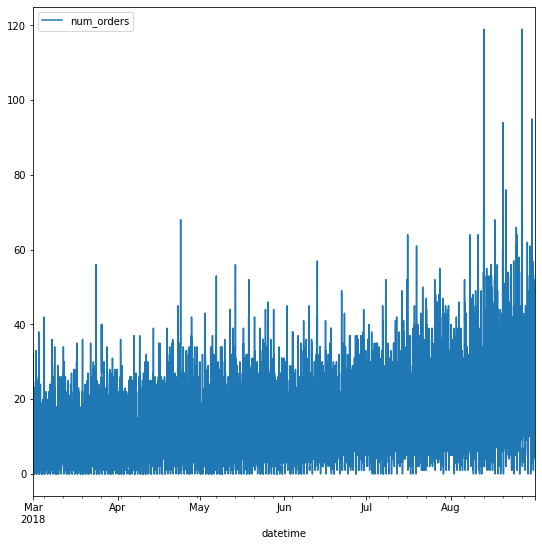

In [4]:
#Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.
#The RMSE metric on the test set should not be more than 48.

taxi.plot(figsize=(9, 9))
print(taxi)

We fix the graph with resampling.
Resampling means changing the interval with the values of the series. It is performed in two steps:
Choose the new interval length. Note that the values from the existing interval are grouped. If the existing interval is ten minutes and we take a new interval that is 30 minutes, then the values from three ten-minute intervals will fall into the new interval.
In each group, the aggregated value of the series is calculated. It can be median, mean, maximum or minimum.

In [6]:
taxi = taxi.resample('1h').sum()

## Analysis

In [7]:
#https://pastebin.com/TXZvrXU7 this was too complicated to keep changing data by time value

#Rolling mean or moving average is a method of smoothing the data in a time series. The method involves finding the values least susceptible to fluctuations, that is, the arithmetic mean.
#Here's how the method works: The interval for averaging (window size) is selected experimentally. The larger the interval, the stronger the smoothing. Then the window starts to "roll" almost from the beginning to the end of the time series. The mean value is calculated at each point.

taxi['mean'] = taxi['num_orders'].rolling(10).mean()

#A stochastic process is stationary if its distribution does not change over time. An example of stationary stochastic process is periodic fluctuations of values.
#If the distribution does change, then the stochastic process is nonstationary.

taxi['std'] = taxi['num_orders'].rolling(10).std()

<AxesSubplot:xlabel='datetime'>

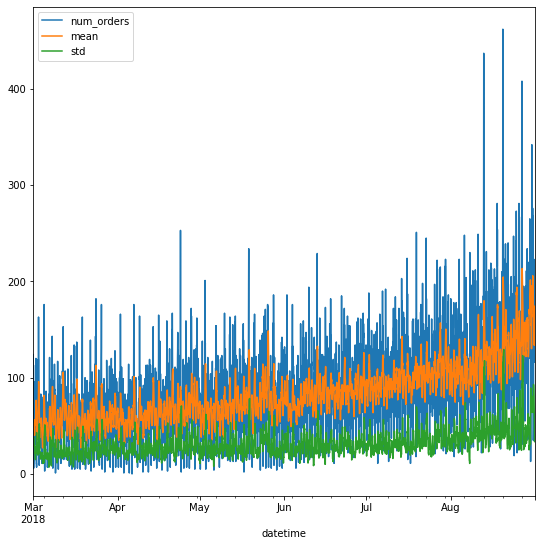

In [8]:
taxi.plot(figsize=(9, 9))

The mean slowly increases over time. As well as that, we have Nonstationary deviation, Nonstationary time series are harder to forecast because their properties change too quickly.

## Training

In [9]:
taxi

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,166.6,35.362252
2018-08-31 20:00:00,154,162.9,34.449480
2018-08-31 21:00:00,159,162.1,34.436576


In [10]:
#Let's move on to training a linear regression model with the new features.

#Let's split the data into training and test sets and derive the features of the latter from the training set. The remaining values and the moving average can be calculated from past data. The features for the first few values of the test set are located at the end of the training set.

#Usually trends and seasonality are linked to a specific date. The datetime64 type in pandas already contains the necessary information, and all that remains is to present it as separate columns. Let's consider this example:

#Rolling mean or moving average is a method of smoothing the data in a time series. The method involves finding the values least susceptible to fluctuations, that is, the arithmetic mean.

def make_features(data, max_lag, rolling_mean_size):
    #this feature contains years as numeric values
    
    #data['year'] = data.index.year The year feature is not very useful as we only have data on one year, so it's a constant feature. On the other hand I would suggest adding an hour feature as we're doing hourly predictions.
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    
make_features(taxi, 6, 10)

#The train_test_split() function from the sklearn.model_selection module mixes data by default, so let's set the shuffle argument to False so the data can be separated correctly into training and test sets:
train, curr = train_test_split(taxi, shuffle=False, test_size=0.2)
valid, test = train_test_split(curr, shuffle=False, test_size=0.5) #valid, test not test,valid
train = train.dropna()

features_train = train.drop(['num_orders'],axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'],axis=1)
target_valid = valid['num_orders']


model = LinearRegression()
model.fit(features_train,target_train)
pred_valid = model.predict(features_valid)
LinearRegression()
print("RMSE for the valid set: ", mean_squared_error(target_valid,pred_valid)**0.5)# < write code here >)

RMSE for the valid set:  25.71114544437207


In [11]:
model = lgb.LGBMRegressor(num_iterations=2000, metric='rmse') 
model.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=100)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	valid_0's rmse: 26.7625
[200]	valid_0's rmse: 26.8478
[300]	valid_0's rmse: 26.9791
[400]	valid_0's rmse: 27.1034
[500]	valid_0's rmse: 27.1413
[600]	valid_0's rmse: 27.1533
[700]	valid_0's rmse: 27.1539
[800]	valid_0's rmse: 27.1607
[900]	valid_0's rmse: 27.1533
[1000]	valid_0's rmse: 27.1627
[1100]	valid_0's rmse: 27.1708
[1200]	valid_0's rmse: 27.1686
[1300]	valid_0's rmse: 27.1673
[1400]	valid_0's rmse: 27.1625
[1500]	valid_0's rmse: 27.162
[1600]	valid_0's rmse: 27.1616
[1700]	valid_0's rmse: 27.1582
[1800]	valid_0's rmse: 27.156
[1900]	valid_0's rmse: 27.1543
[2000]	valid_0's rmse: 27.1541


LGBMRegressor(metric='rmse', num_iterations=2000)

In [12]:
model = CatBoostRegressor(loss_function='RMSE', iterations=2000)
model.fit(features_train, target_train, verbose=100)
pred_valid = model.predict(features_valid)
print("RMSE for the valid set:", mean_squared_error(target_valid,pred_valid)**0.5)

Learning rate set to 0.028434
0:	learn: 35.1724000	total: 48.1ms	remaining: 1m 36s
100:	learn: 20.5716012	total: 222ms	remaining: 4.18s
200:	learn: 17.8701042	total: 388ms	remaining: 3.47s
300:	learn: 16.1198829	total: 557ms	remaining: 3.15s
400:	learn: 14.7407343	total: 722ms	remaining: 2.88s
500:	learn: 13.6067178	total: 890ms	remaining: 2.66s
600:	learn: 12.7484342	total: 1.06s	remaining: 2.48s
700:	learn: 11.9983589	total: 1.25s	remaining: 2.33s
800:	learn: 11.3947187	total: 1.43s	remaining: 2.13s
900:	learn: 10.7728922	total: 1.59s	remaining: 1.94s
1000:	learn: 10.2657104	total: 1.78s	remaining: 1.77s
1100:	learn: 9.8252359	total: 1.96s	remaining: 1.6s
1200:	learn: 9.4133753	total: 2.13s	remaining: 1.42s
1300:	learn: 9.0462795	total: 2.31s	remaining: 1.24s
1400:	learn: 8.6893932	total: 2.48s	remaining: 1.06s
1500:	learn: 8.3585682	total: 2.65s	remaining: 881ms
1600:	learn: 8.0657259	total: 2.82s	remaining: 702ms
1700:	learn: 7.8040091	total: 2.99s	remaining: 525ms
1800:	learn: 7.5

In [13]:
rsmes = []

for depth in range(1,5):
    for est in range(1,100,10):
        model = RandomForestRegressor(n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        pred_valid = model.predict(features_valid)
        rsmes.append(mean_squared_error(target_valid,pred_valid)**0.5)

print('mean RMSE for the valid set:', statistics.mean(rsmes))
print(); print(model)

mean RMSE for the valid set: 44.82445849071274

RandomForestRegressor(max_depth=4, n_estimators=91)


In [17]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
pred_valid = dummy_regr.predict(features_valid)
DummyRegressor()
print("RMSE for the valid set: ", mean_squared_error(target_valid,pred_valid)**0.5)# < write code here >)

RMSE for the valid set:  58.1961228550993


In [18]:
#The point of time series forecasting is developing a model which predicts the future values of a time series based on previous data.

#The length of time into the future for which the forecast is prepared is called a forecast horizon. We will use a one-step horizon for the tasks in this chapter.



#A better baseline for time series models is a model using previous values as predictions
train, test = train_test_split(taxi, shuffle=False, test_size=0.2)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

##There are two ways to forecast time series without training:

#All values of the test sample are predicted with the same number (a constant). For the MAE metric, this number is the median.

print('Median orders per hour:', test['num_orders'].median())
pred_median = np.ones(test.shape) * test['num_orders'].median()

#We'll be using the MAE metric to evaluate the models in our tasks because this metric is easily interpretable.
print('Median RMSE:', mean_squared_error(test,pred_median)**0.5)

#The new value x(t) is predicted by the previous value in the series, defined as x(t-1). This method is metric-independent. Note that the latest value of the train data can be used as the first value of the test data.

#To predict the values, call the shift() method from the test set. To determine the first value, study how the iloc attribute works (integer location based indexing).

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE', mean_squared_error(test,pred_previous)**0.5)

2018-03-01 00:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-31 23:00:00
Median orders per hour: 120.0
Median RMSE: 74.059585879444
RMSE 38.016536626188554



## Testing

In [16]:
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

model = LinearRegression()
model.fit(features_train,target_train)
pred_test = model.predict(features_test)

print("RMSE for the test set: ", mean_squared_error(target_test,pred_test)**0.5)# < write code here >)

RMSE for the test set:  29.868056207968227


Lowest RSME is LinearRegression. So it is the best one to use.


# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48